# Model Training

Functionalities- 
1. Data load
2. Build model
3. Train model
4. Save model
5. make predictions
6. convert the H5 to pb file


## Initialization

In [1]:
import time
import os
import json
import tensorflow.compat.v1 as tf
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import (Input, AveragePooling2D, Dropout, Flatten, Dense) 
from tensorflow.keras.models import Model
from tensorflow.python.framework import graph_util, graph_io
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import load_model
import numpy as np

## Json parser 

In [2]:
configfile = './config.json'
with open(configfile) as read_buffer:
    config_file = json.loads(read_buffer.read())
    image_H = config_file["input_H"]
    image_W = config_file["input_W"]
    num_epochs = config_file["num_epochs"]
    batch_size = config_file["batch_size"]
    tensorboard_steps = config_file["tensorboard_steps"]
    log_path = config_file["log_dir"]
    num_class = config_file["num_class"]
    trainset_path =  config_file["train_path"]
    valset_path = config_file["val_path"]
    testset_path = config_file["test_path"]

## Data Loader 

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale= 1./ 255)

train_generator = train_datagen.flow_from_directory(
        trainset_path,
        target_size=(image_H, image_W),
        batch_size= batch_size,
        shuffle=True,
        class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
        valset_path,
        target_size=(image_H, image_W),
        batch_size= batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    testset_path,
    target_size=(image_H, image_W),
    batch_size=1, 
    class_mode='categorical')

Found 706 images belonging to 3 classes.
Found 107 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### Data visualization

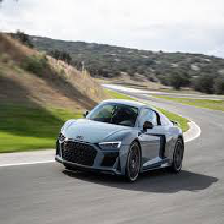

In [4]:
def load_an_image(file_name):
    file_path = os.path.join(os.getcwd() + '/'+  trainset_path,  file_name)
    img = image.load_img(file_path, color_mode='rgb', target_size=(image_H, image_W))
    return img

# Pass an image for visualization
load_an_image(train_generator.filenames[0]) 

## Bulid Model

### Transfer learning using imagenet pretrained weights 

In [5]:
# load the MobileNetV2/ResNet50 network

baseModel = applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu", name="dense_vector")(headModel)
headModel = Dropout(0.7)(headModel)
headModel = Dense(num_class, activation="softmax")(headModel)

# build model
model = Model(inputs=baseModel.input, outputs=headModel)

# base model layer freeze
for layer in baseModel.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Model compile 

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Model Train 

In [7]:
# data log file format
time_str = time.strftime('%Y-%m-%d-%H-%M')
log_dir =  log_path + '/' + str(time_str)
tenosor_dir = log_dir + '/logs'

# tensorbord log after every epoch
callbacks_model_save = [
       tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(tenosor_dir),
            update_freq=tensorboard_steps,
            histogram_freq=0,
            embeddings_freq=0,
            profile_batch=0,
            write_graph=False,
            write_images=False,
        ),
        tf.keras.callbacks.EarlyStopping(patience=10)]

# train
model.fit(
    train_generator,
    steps_per_epoch= 706 // batch_size, 
    epochs=num_epochs,
    callbacks=[callbacks_model_save],
    validation_data=val_generator,
    validation_steps= 107 // batch_size,
    verbose = 1)

Epoch 1/30
22/22 [==============================] - 15s 580ms/step - loss: 1.5059 - accuracy: 0.3354 - val_loss: 1.0340 - val_accuracy: 0.4375
Epoch 2/30
22/22 [==============================] - 12s 546ms/step - loss: 1.0898 - accuracy: 0.4111 - val_loss: 1.0295 - val_accuracy: 0.4583
Epoch 3/30
22/22 [==============================] - 12s 541ms/step - loss: 1.0781 - accuracy: 0.4274 - val_loss: 0.9667 - val_accuracy: 0.5521
Epoch 4/30
22/22 [==============================] - 14s 608ms/step - loss: 1.0436 - accuracy: 0.4351 - val_loss: 0.9765 - val_accuracy: 0.5417
Epoch 5/30
22/22 [==============================] - 12s 548ms/step - loss: 1.0332 - accuracy: 0.4561 - val_loss: 0.9269 - val_accuracy: 0.5521
Epoch 6/30
22/22 [==============================] - 12s 548ms/step - loss: 1.0260 - accuracy: 0.4914 - val_loss: 0.8990 - val_accuracy: 0.6250
Epoch 7/30
22/22 [==============================] - 12s 536ms/step - loss: 0.9519 - accuracy: 0.5345 - val_loss: 0.8654 - val_accuracy: 0.6042

###  Model save

In [8]:
model.save(log_dir + '/final_state_model.h5') 

## Prediction 

Car predictions for Image audi/0.jpg: Audi:14.727923%, Benz:34.155197%, BMW:51.116882%


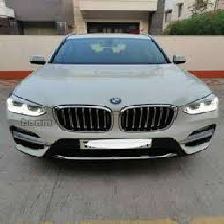

In [10]:
def load_an_image_test(file_name):
    file_path = os.path.join(os.getcwd() + '/' + testset_path,  file_name)
    img = image.load_img(file_path, color_mode='rgb', target_size=(image_H, image_W))
    return img

# Prediction
preds = model.predict(test_generator, steps=15)
preds = preds * 100

# Specify test image index
image_index = 11
if image_index < len(test_generator):
    print('Car predictions for Image {}: Audi:{}%, Benz:{}%, BMW:{}%'.format(test_generator.filenames[0],
                                                                   np.array2string(preds[image_index][0]),
                                                                   np.array2string(preds[image_index][1]),
                                                                   np.array2string(preds[image_index][2])))
else:
    raise IndexError
    
load_an_image_test(test_generator.filenames[image_index]) 

### Convert H5 to pb

In [11]:
def convert():
    path = log_dir + '/final_state_model.h5'
    tf.compat.v1.disable_eager_execution()
    model_h5 =load_model(path)
    K.set_image_data_format('channels_last')

    output_node_name = [node.op.name for node in model_h5.outputs]

    sess = tf.keras.backend.get_session()

    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), output_node_name)
    graph_io.write_graph(constant_graph, log_dir, 'tensorflow_graph.pb', as_text=False)
    print('conversion completed')
    
convert()

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
conversion completed
